# CPTox21: Conformal prediction and exchangeability in in vitro toxicological datasets

This notebooks demonstrates the main workflow to obtain the results for the manuscript ...

### Import libraries and modules

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.svm import SVC
from nonconformist.nc import NcFactory, MarginErrFunc

In [3]:
from cptox21 import (
    define_path, load_signatures_files, StratifiedRatioSampler,CrossValidationSampler,
    KnownIndicesSampler, InductiveConformalPredictor,
    AggregatedConformalPredictor, CPTox21AggregatedConformalPredictor, 
    CPTox21CrossValidator, CPTox21TrainUpdateCrossValidator
)

In [4]:
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(
    filename='test_logger.log',
    filemode='w',
    level=logging.INFO)

console = logging.StreamHandler()
console.setLevel(logging.INFO) #WARNING)
logging.getLogger('').addHandler(console)

### Define paths and parameters

In [5]:
data_signatures_path = "../data/data_signatures/"
# data_models_path = args["data_models_path"]
data_statistics_path = "../data/data_statistics/"

In [6]:
endpoint = "NR_ER"

In [7]:
# CP
n_folds_acp = 2

#### Build ICP classifier

In [8]:
clf = SVC(kernel='rbf', C=50, gamma=0.002, probability=True)
error_function = MarginErrFunc()
normaliser_model = None
nc = NcFactory.create_nc(
    clf, err_func=error_function
)
icp = InductiveConformalPredictor(
        nc_function=nc, condition=(lambda instance: instance[1])
    )  # Mondrian as (default) condition)

#### Build ACP for main framework and for train_update

In [9]:
acp = CPTox21AggregatedConformalPredictor(
        predictor=icp, sampler=StratifiedRatioSampler(n_folds=n_folds_acp),
        aggregation_func=np.median
    )

#### Load data

In [10]:
datasets = ["train", "test", "score"]
train_path = define_path(endpoint=endpoint, data=datasets[0], signatures_path=data_signatures_path)
test_path = define_path(endpoint=endpoint, data=datasets[1], signatures_path=data_signatures_path)
score_path = define_path(endpoint=endpoint, data=datasets[2], signatures_path=data_signatures_path)

X_train, y_train, X_test, y_test, X_score, y_score = load_signatures_files(train_path, test_path, score_path)
X_train = X_train[:500]
y_train = y_train[:500]

#### Define crossvalidator, which does all acp experiments except for train_update

In [11]:
cross_validator = CPTox21CrossValidator(
            acp, cv_splitter=CrossValidationSampler(),
            score_splitter=StratifiedRatioSampler(test_ratio=0.5)
        )

#### Crossvalidate

In [12]:
cross_validation_dfs = cross_validator.cross_validate(
            steps=10,
            endpoint=endpoint,
            X_train=X_train,
            y_train=y_train,
            X_update=X_test,
            y_update=y_test,
            X_score=X_score,
            y_score=y_score,
        )
# [df[["validity", "efficiency", "accuracy", "significance_level"]].head() for df in cross_validation_dfs]

fitting and calibrating ACP


len score 245 245


<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
crossvalidation prediction with original calibration set
predict external data with original calibration set
predict external data with updated calibration set
predict part of external data with model calibrated with (other) part of external data
fitting and calibrating ACP


len score 245 245


<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
crossvalidation prediction with original calibration set
predict external data with original calibration set
predict external data with updated calibration set
predict part of external data with model calibrated with (other) part of external data
fitting and calibrating ACP


len score 245 245


<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
crossvalidation prediction with original calibration set
predict external data with original calibration set
predict external data with updated calibration set
predict part of external data with model calibrated with (other) part of external data
fitting and calibrating ACP


len score 245 245


<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
crossvalidation prediction with original calibration set
predict external data with original calibration set
predict external data with updated calibration set
predict part of external data with model calibrated with (other) part of external data
fitting and calibrating ACP


len score 245 245


<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
crossvalidation prediction with original calibration set
predict external data with original calibration set
predict external data with updated calibration set
predict part of external data with model calibrated with (other) part of external data


#### Get splits from crossvalidator, so that exactly the same splits can be used for train_update

In [13]:
train_index, test_index = cross_validator.train_indices, cross_validator.test_indices

known_indices_sampler = KnownIndicesSampler(known_train=train_index, known_test=test_index)

#### Define ACP for train_update
Difference to CPTox21AggregatedConformalPredictor: No further updating of the calibration set required for this experiment. Here, we can use a 'typical' ACP.

In [14]:
train_update_acp = AggregatedConformalPredictor(
        predictor=icp, sampler=StratifiedRatioSampler(n_folds=n_folds_acp),
        aggregation_func=np.median
    )

#### Define train_update crossvalidator using same splits as before and crossvalidate

In [15]:
train_update_cross_validator = CPTox21TrainUpdateCrossValidator(
    train_update_acp, cv_splitter=known_indices_sampler
)

train_update_cross_validation_dfs = train_update_cross_validator.cross_validate(steps=10,
                                           endpoint=endpoint,
                                           X_train=X_train,
                                           y_train=y_train,
                                           X_update=X_test,
                                           y_update=y_test,
                                           X_score=X_score,
                                           y_score=y_score,
                                           class_wise_evaluation=False)

[df[["validity", "efficiency", "accuracy", "significance_level"]].head() for df in train_update_cross_validation_dfs]

<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.


[   validity  efficiency  accuracy  significance_level
 0      1.00        0.00     0.000                 0.0
 1      0.97        0.30     0.900                 0.1
 2      0.86        0.67     0.791                 0.2
 3      0.79        0.92     0.783                 0.3
 4      0.69        0.87     0.793                 0.4,
    validity  efficiency  accuracy  significance_level
 0     1.000       0.000     0.000                 0.0
 1     0.973       0.151     0.824                 0.1
 2     0.876       0.451     0.724                 0.2
 3     0.737       0.935     0.727                 0.3
 4     0.565       0.731     0.774                 0.4]

### Plots

In [16]:
plots = {}

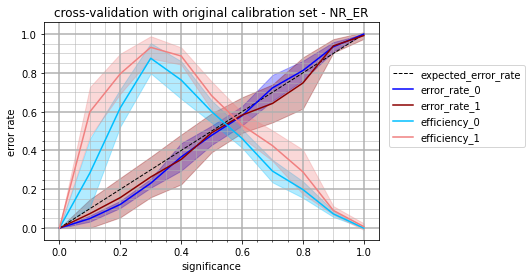

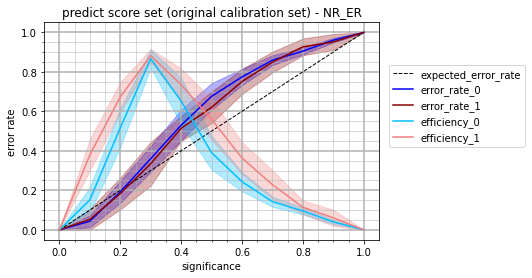

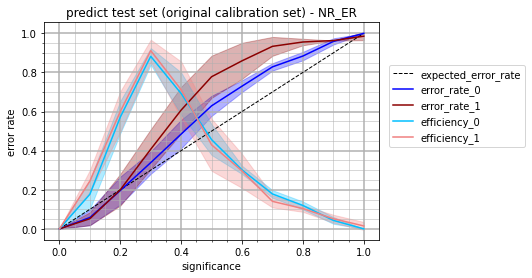

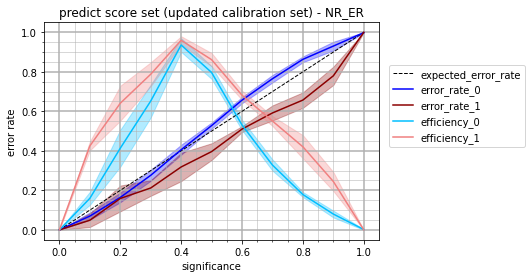

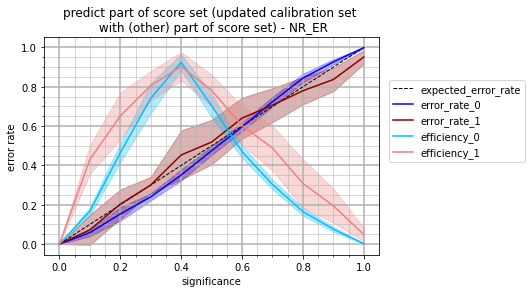

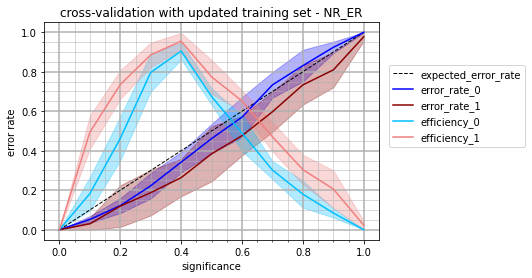

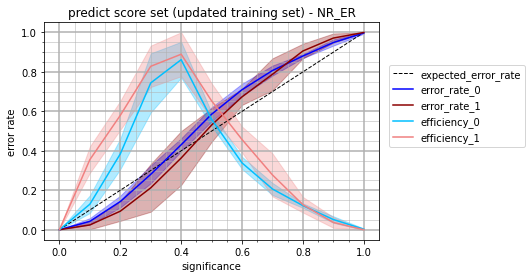

In [17]:
plots["cv"] = cross_validator.calibration_plot( 
    averaged_evaluation_df=cross_validator.averaged_evaluation_df_cv,
            endpoint=endpoint, title_name="cross-validation with original calibration set"
        )
plots["pred_score"] = cross_validator.calibration_plot(
            averaged_evaluation_df=cross_validator.averaged_evaluation_df_pred_score,
            endpoint=endpoint, title_name="predict score set (original calibration set)"
        )
plots["pred_test"] = cross_validator.calibration_plot(
            averaged_evaluation_df=cross_validator.averaged_evaluation_df_pred_test,
            endpoint=endpoint, title_name="predict test set (original calibration set)"
        )
plots["cal_update"] = cross_validator.calibration_plot(
            averaged_evaluation_df=cross_validator.averaged_evaluation_df_pred_cal_update,
            endpoint=endpoint, title_name="predict score set (updated calibration set)"
        )
plots["cal_update2"] = cross_validator.calibration_plot(
            averaged_evaluation_df=cross_validator.averaged_evaluation_df_pred_cal_update2,
            endpoint=endpoint, title_name="predict part of score set (updated calibration \
set \n with (other) part of score set)"
        )
plots["train_update_cv"] = train_update_cross_validator.calibration_plot(
            averaged_evaluation_df=train_update_cross_validator.averaged_evaluation_df_cv,
            endpoint=endpoint, title_name="cross-validation with updated training set"
        )
plots["train_update_pred_score"] = train_update_cross_validator.calibration_plot(
            averaged_evaluation_df=train_update_cross_validator.averaged_evaluation_df_pred_score,
            endpoint=endpoint, title_name="predict score set (updated training set)"
        )